Dataset:
[https://drive.google.com/file/d/1yL_fysiQE9KZYP8YrRhuRx6RY1LtL14u/view?usp=sharing](Dataset)

# Model

In [1]:
import torch
import torch.nn as nn

In [2]:
class Discriminator(nn.Module):
    def __init__(self, input_dimension, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x input_dimention x 64 x 64
            nn.Conv2d(
                input_dimension, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4,4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            #nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
      return self.disc(x)

In [3]:
class Generator(nn.Module):
  def __init__(self, channels_noise, input_dimension, features_g):
    super(Generator, self).__init__()
    self.dropout = nn.Dropout(p=0.5) #Valor por default
    self.net = nn.Sequential(
        # Input: N x channels_noise x 1 x 1
        self._block(channels_noise, features_g * 16, 4, 1, 0),
        self._block(features_g * 16, features_g * 8, 4, 2, 1), #1024
        self._block(features_g * 8, features_g * 4, 4, 2, 1),
        self._block(features_g * 4, features_g * 2, 4, 2, 1),
        nn.ConvTranspose2d(
            features_g * 2, input_dimension, kernel_size=4, stride=2, padding=1
        ),
        nn.Tanh(),
    )
  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            bias=False,
        ),
        nn.ReLU(),
    )
  def forward(self, x):
    x = self.dropout(x)
    return self.net(x)

In [4]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def test():
  #Batch, channels, height, width
  x = torch.randn((8, 1, 64, 64)).to(device)
  # Discriminador(input_dimention, features_d)
  disc = Discriminator(1,8).to(device)
  print("disc.shape = ", disc(x).shape)
  gen = Generator(100, 1, 8).to(device)
  z = torch.randn((8, 100, 1, 1)).to(device)
  print("gen.shape = ", gen(z).shape) #(N, in_channels, H, W)

test()

disc.shape =  torch.Size([8, 1, 1, 1])
gen.shape =  torch.Size([8, 1, 64, 64])


# Preprocessing

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import os

#Descomprimir
import tarfile
tar = tarfile.open('/content/drive/MyDrive/midi.tar', 'r:')
tar.extractall()
tar.close()

#Comprobar las carpetas
os.listdir()

['.config', 'midi', 'drive', 'sample_data']

In [8]:
from music21 import *
import glob

In [15]:
class MidiDataset(torch.utils.data.Dataset):
  def __init__(self, transform=None):
    self.transform = transform
    self.midi = []
    self.diccionario = self.all_notes()
    for file in glob.glob("/content/midi/*.mid"):
      self.midi.append(converter.parse(file))
        
  def __len__(self):
    return len(self.midi)

  def __getitem__(self, idx):
    notes = []
    val = self.midi[idx]
    for element in val.recurse():
      if isinstance(element, note.Note):
        notes.append(str(element.pitch)) #Obtiene el tono de la nota
      elif isinstance(element, chord.Chord):
        notes.append('.'.join(str(n) for n in element.normalOrder))
    
    notes = self.get_notes(notes)
    #notes = notes[notes != np.array(None)]   notes = np.asarray(notes)
    notes = [x for x in notes if x != None]
    if len(notes) < 4097:
      for i in range(4096-len(notes)):
        notes.append(notes[i])
    notes = notes[:4096]

    notes = np.asarray(notes)
    notes = notes.reshape(64,64)
    #print("dtype", notes.dtype)

    if self.transform:
      notes = self.transform(notes)

    return notes

  def all_notes(self):
    #Obtiene las notas de los archivos midi
    dicc = []
    for file in glob.glob("/content/midi/*.mid"):
      midi = converter.parse(file)
    for element in midi.recurse():
        if isinstance(element, note.Note):
          dicc.append(str(element.pitch)) #Obtiene el tono de la nota
        elif isinstance(element, chord.Chord):
          dicc.append('.'.join(str(n) for n in element.normalOrder))
    # Obtiene el nombre de los tonos
    pitchnames = sorted(set(item for item in dicc))
    # Crea un diccionario de tonos y numeros enteros
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
    print("note_to_int all_notes", note_to_int)
    return note_to_int

  def get_notes(self, tonos):
    notes = []
    for char in tonos:
      notes.append(self.diccionario.get(char))
    return notes


# Métrica

In [ ]:
import torchvision.models as models
import torch.nn.functional as F

In [ ]:
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps
        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)
        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp


In [ ]:
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3([block_idx])
model=model.cuda()

In [ ]:
import numpy as np
def calculate_activation_statistics(images,model,batch_size=128, dims=2048,
                    cuda=False):
    model.eval()
    act=np.empty((len(images), dims))
    
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

In [ ]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [ ]:
def calculate_fretchet(images_real,images_fake,model):
     mu_1,std_1=calculate_activation_statistics(images_real,model,cuda=True)
     mu_2,std_2=calculate_activation_statistics(images_fake,model,cuda=True)
    
     """get fretched distance"""
     fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
     return fid_value

# Training

In [19]:
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np

In [16]:
torch.cuda.empty_cache()

In [12]:
# Hyperparameters etc.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 2e-4
batch_size = 128
dimension = 1
noise_dim = 100
num_epochs = 5
features_dic = 64
features_gen = 64

In [17]:
def get_transform():
    transforms_midi = []
    transforms_midi.append(transforms.ToTensor())
    return transforms.Compose(transforms_midi)

In [20]:
dataset = MidiDataset(transform=get_transform())
print("len dataset", len(dataset))

note_to_int all_notes {'0': 0, '0.3': 1, '0.3.5': 2, '0.4': 3, '0.5': 4, '1': 5, '1.5': 6, '10': 7, '10.0': 8, '10.0.4': 9, '10.1': 10, '10.1.5': 11, '10.2': 12, '10.2.5': 13, '10.3': 14, '11': 15, '11.0': 16, '11.2': 17, '2': 18, '2.4': 19, '2.5': 20, '2.8': 21, '3': 22, '3.5': 23, '3.5.9': 24, '3.6': 25, '3.7': 26, '3.7.10': 27, '3.9': 28, '4': 29, '4.5.7.10.0': 30, '4.7': 31, '5': 32, '5.10': 33, '5.11': 34, '5.7': 35, '5.8': 36, '5.8.0': 37, '5.8.10': 38, '5.9': 39, '5.9.0': 40, '6': 41, '6.10': 42, '7': 43, '7.0': 44, '7.10': 45, '7.10.2': 46, '8': 47, '8.0': 48, '8.11': 49, '9': 50, '9.0': 51, '9.0.3': 52, '9.1': 53, '9.10.0.3.5': 54, '9.11': 55, '9.2': 56, 'A2': 57, 'A3': 58, 'A4': 59, 'A5': 60, 'B-1': 61, 'B-2': 62, 'B-3': 63, 'B-4': 64, 'B-5': 65, 'B2': 66, 'B3': 67, 'B4': 68, 'B5': 69, 'C#2': 70, 'C#3': 71, 'C#4': 72, 'C#5': 73, 'C#6': 74, 'C2': 75, 'C3': 76, 'C4': 77, 'C5': 78, 'C6': 79, 'D2': 80, 'D3': 81, 'D4': 82, 'D5': 83, 'D6': 84, 'E-2': 85, 'E-3': 86, 'E-4': 87, 'E-5'

In [21]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
gen = Generator(noise_dim, dimension, features_gen).to(device)
disc = Discriminator(dimension, features_dic).to(device)
initialize_weights(gen)
initialize_weights(disc)

In [22]:
opt_gen = optim.Adam(gen.parameters(), lr=learning_rate, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=learning_rate, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(32, noise_dim, 1, 1).to(device)
step = 0

In [23]:
disc.train()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
    (6): Sigmoid()
  )
)

In [24]:
gen.train()

Generator(
  (dropout): Dropout(p=0.5, inplace=False)
  (net): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU()
    )
    (4): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): Tanh()
  )
)

In [25]:
list_loss_disc = []
list_loss_gen = []
for epoch in range(num_epochs):
  for batch_idx, real in enumerate(dataloader):
    #print("real dtype", real.dtype)
    real = real.to(device)
    noise = torch.randn(batch_size, noise_dim, 1, 1).to(device)
    fake = gen(noise)

    #El modelo Inception está entrenado para manejar 3 canales
    #real_inception = torch.cat((real, real, real),1)
    #fake_inception = torch.cat((fake, fake, fake),1)

    ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
    disc_real = disc(real.float()).reshape(-1)
    loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
    disc_fake = disc(fake.detach()).reshape(-1)
    loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
    loss_disc = (loss_disc_real + loss_disc_fake) / 2
    disc.zero_grad()
    loss_disc.backward()
    opt_disc.step()

    ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
    output = disc(fake).reshape(-1)
    loss_gen = criterion(output, torch.ones_like(output))
    gen.zero_grad()
    loss_gen.backward()
    opt_gen.step()

    # Print losses occasionally and print to tensorboard
    if batch_idx % 10 == 0:
      list_loss_disc.append(loss_disc)
      list_loss_gen.append(loss_gen)
      #fretchet_dist=calculate_fretchet(real_inception,fake_inception,model)   #Calcula la métrica
      print(
        f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(dataloader)} \
        Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
        )
      #, Fretchet_Distance: {fretchet_dist:.4f}

      with torch.no_grad():
        new = gen(fixed_noise)
        #generate(dicc, epoch)
      step += 1

Epoch [0/5] Batch 0/3         Loss D: 0.6354, loss G: 0.6036
Epoch [1/5] Batch 0/3         Loss D: 0.3347, loss G: 0.8636
Epoch [2/5] Batch 0/3         Loss D: 0.1647, loss G: 1.7241
Epoch [3/5] Batch 0/3         Loss D: 0.0355, loss G: 3.4070
Epoch [4/5] Batch 0/3         Loss D: 0.0057, loss G: 4.8898


In [ ]:
#fretchet_dist=calculate_fretchet(real_inception,fake_inception,model)

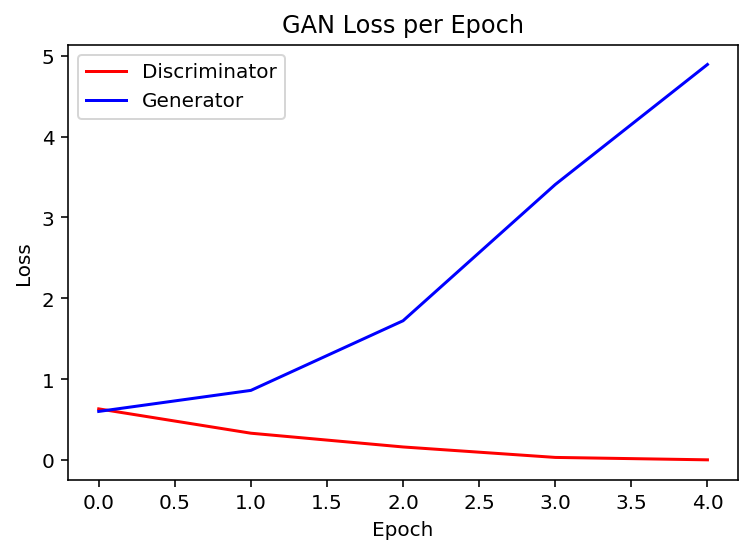

In [26]:
import numpy as np
import matplotlib.pyplot as plt
def plot_loss():
        plt.plot(list_loss_disc, c='red')
        plt.plot(list_loss_gen, c='blue')
        plt.title("GAN Loss per Epoch")
        plt.legend(['Discriminator', 'Generator'])
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        #plt.savefig('GAN_Loss_per_Epoch_final.png', transparent=True)
        plt.show()
        #plt.close()
plot_loss()

# Generate

In [27]:
def create_midi(prediction_output, filename):
    offset = 0
    output_notes = []

    for item in prediction_output:
        pattern = item[0]
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        offset += 0.5

    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='{}.mid'.format(filename))

In [28]:
def generate(dicc):
  pitchnames = dicc.keys()
  print("len pitchnames", len(pitchnames))
  int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
  fixed_noise = torch.randn(32, noise_dim, 1, 1).to(device)
  fake = gen(fixed_noise)
  print("fake shape: ", fake.shape)
  fake = fake[0].resize(1, 64*64)
  print("fake", fake[0,100:200])
  pred_notes = fake[0]*34+34
  print("pred desnorm", pred_notes[100:200])
  pred_notes = [int_to_note[int(x)] for x in pred_notes]
  print("pred int", pred_notes)
      
  create_midi(pred_notes, 'gan_final')

In [29]:
dicc = dataset.diccionario
generate(dicc)

len pitchnames 116
fake shape:  torch.Size([32, 1, 64, 64])
fake tensor([ 0.9232,  0.9811, -0.9327,  0.9779, -0.1319,  0.9360, -0.9811,  0.9880,
         0.9265,  0.9864, -0.9258,  0.9748, -0.3815,  0.9210, -0.9763,  0.9724,
         0.8833,  0.9520, -0.8691,  0.9374, -0.1048,  0.8391, -0.8965,  0.8574,
         0.6420,  0.6255, -0.3872,  0.1521, -0.1273,  0.6225,  0.4147, -0.8948,
        -0.2025,  0.8226,  0.7639,  0.1970, -0.9284,  0.8882,  0.9168, -0.9888,
        -0.4454,  0.9260,  0.8350,  0.0350, -0.9803,  0.9366,  0.9298, -0.9960,
        -0.4301,  0.9191,  0.8888,  0.1904, -0.9770,  0.9318,  0.9581, -0.9942,
        -0.4950,  0.9296,  0.8450,  0.0021, -0.9793,  0.9365,  0.9292, -0.9963,
        -0.4631,  0.9145,  0.8921,  0.1808, -0.9761,  0.9295,  0.9554, -0.9945,
        -0.5005,  0.9252,  0.8598,  0.0470, -0.9789,  0.9158,  0.9209, -0.9918,
        -0.3755,  0.8429,  0.8072,  0.1109, -0.9296,  0.7535,  0.8512, -0.9171,
        -0.3665,  0.2992,  0.3455, -0.0471,  0.0678,  0

/usr/local/lib/python3.7/dist-packages/torch/tensor.py:474: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


# Export

In [30]:
#tracing

traced_model = torch.jit.trace(gen.cuda(), fixed_noise)
traced_model.save('gen.zip')

/usr/local/lib/python3.7/dist-packages/torch/jit/_trace.py:966: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
With rtol=1e-05 and atol=1e-05, found 118703 element(s) (out of 131072) whose difference(s) exceeded the margin of error (including 0 nan comparisons). The greatest difference was 0.20057490468025208 (0.6767550706863403 vs. 0.47618016600608826), which occurred at index (18, 0, 39, 13).
  _module_class,


In [32]:
loaded_model = torch.jit.load('gen.zip')
loaded_model.eval()

RecursiveScriptModule(
  original_name=Generator
  (dropout): RecursiveScriptModule(original_name=Dropout)
  (net): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(original_name=ConvTranspose2d)
      (1): RecursiveScriptModule(original_name=ReLU)
    )
    (1): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(original_name=ConvTranspose2d)
      (1): RecursiveScriptModule(original_name=ReLU)
    )
    (2): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(original_name=ConvTranspose2d)
      (1): RecursiveScriptModule(original_name=ReLU)
    )
    (3): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(original_name=ConvTranspose2d)
      (1): RecursiveScriptModule(original_name=ReLU)
    )
    (4): RecursiveScriptModule(original_name=ConvTranspose2d)
    (5): RecursiveScriptMo